In [1]:
import sys
sys.path.append("..")

from datetime import datetime
import numpy as np
import ujson as json
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from lib.dataclasses import SignalDCT, SignalTime, SingleSample, Sample, SignalSpectrum
from lib.utils import get_sample_from_json
from copy import deepcopy

In [2]:
import networkx as nx

In [3]:
import warnings
warnings.filterwarnings("ignore") # disable due to kmeans initialization

In [4]:
plt.style.use('ggplot')
from matplotlib.gridspec import GridSpec

In [5]:
PATH_TO_DATASET_1 = "/workspaces/project/raw/sequence_1/"
PATH_TO_DATASET_2 = "/workspaces/project/raw/sequence_2/"

# Importing data

In [6]:
band_limits = [
    0,
    5,
    20,
    32,
    40,
    55,
    75,
    100,
    120,
    128
]

In [7]:
band_pairs = [(band_limits[i], band_limits[i+1]) for i in range(len(band_limits)-1)]

Dataset 1

In [28]:
valid_date = datetime(2022, 11, 18, 10, 19)

band_matrices_dataset_1 = {f"{cable}": [] for cable in range(4)}
tensions_dataset_1 = {f"{cable}": [] for cable in range(4)}
dates_1 = []
for file_path in tqdm(os.listdir(PATH_TO_DATASET_1)):
    sample_id = file_path.split(".json")[0]
    date = datetime.strptime(sample_id, "%Y_%m_%d_%H_%M")
    dates_1.append(date)
    if date >= valid_date:
        sample = get_sample_from_json(
            path = PATH_TO_DATASET_1 + file_path,
            sample_id=sample_id
        )

        for cable in range(4):
            band_matrix = np.zeros(len(band_pairs))
            for j, pair in enumerate(band_pairs):
                combined = SignalDCT.combine(sample[cable]["y"], sample[cable]["z"])
                band_matrix[j] = combined.get_frequency_center([pair[0], pair[1]])
            band_matrices_dataset_1[f"{cable}"].append(band_matrix)
            tensions_dataset_1[f"{cable}"].append(sample[cable].tension)

for cable in range(4):
    band_matrices_dataset_1[f"{cable}"] = np.array(band_matrices_dataset_1[f"{cable}"])
        

100%|██████████| 2865/2865 [01:07<00:00, 42.16it/s] 


Dataset 2

In [30]:
valid_date = datetime(2023, 1, 7, 10, 00)

band_matrices_dataset_2 = {f"{cable}": [] for cable in range(4)}
tensions_dataset_2 = {f"{cable}": [] for cable in range(4)}
dates_2 = []
for file_path in tqdm(os.listdir(PATH_TO_DATASET_2)):
    sample_id = file_path.split(".json")[0]
    date = datetime.strptime(sample_id, "%Y_%m_%d_%H_%M")
    dates_2.append(date)
    if date >= valid_date:
        sample = get_sample_from_json(
            path = PATH_TO_DATASET_2 + file_path,
            sample_id=sample_id
        )

        for cable in range(4):
            band_matrix = np.zeros(len(band_pairs))
            for j, pair in enumerate(band_pairs):
                combined = SignalDCT.combine(sample[cable]["y"], sample[cable]["z"])
                band_matrix[j] = combined.get_frequency_center([pair[0], pair[1]])
            band_matrices_dataset_2[f"{cable}"].append(band_matrix)
            tensions_dataset_2[f"{cable}"].append(sample[cable].tension)

for cable in range(4):
    band_matrices_dataset_2[f"{cable}"] = np.array(band_matrices_dataset_2[f"{cable}"])
        

100%|██████████| 4420/4420 [01:56<00:00, 38.00it/s]


Normalizing by bandwidth

In [10]:
# bandwidths = np.array([pair[1]-pair[0] for pair in band_pairs])
# bandwidths = np.expand_dims(bandwidths, 0)

In [11]:
# for k in band_matrices_dataset_2.keys():
#     band_matrices_dataset_1[k] = band_matrices_dataset_1[k] / bandwidths
#     band_matrices_dataset_2[k] = band_matrices_dataset_2[k] / bandwidths

# Visualization

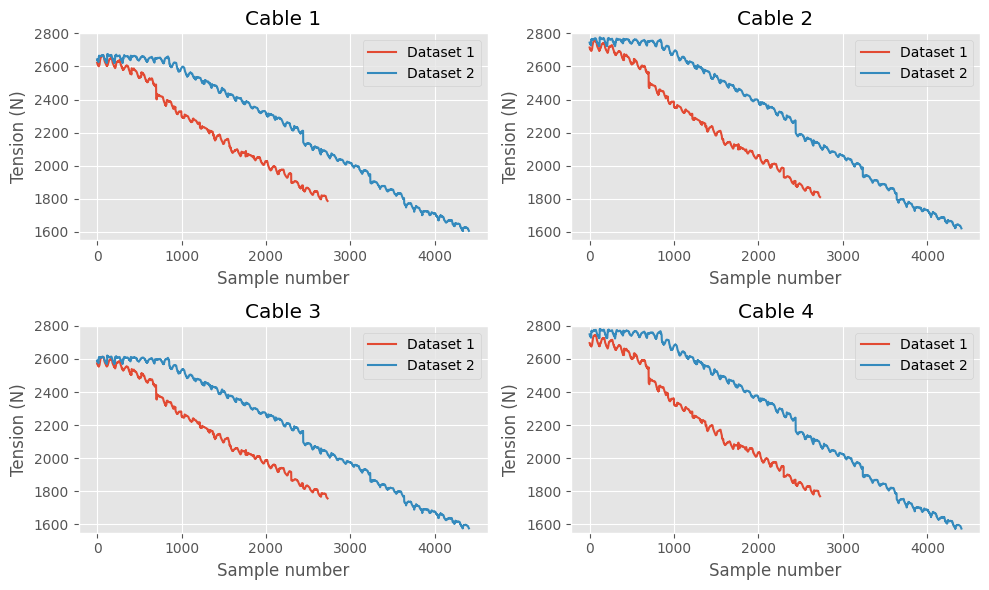

In [12]:
plt.figure(figsize=(10,6))

for cable in range(4):
    plt.subplot(2,2,cable+1)
    plt.title(f"Cable {cable+1}")
    plt.plot(tensions_dataset_1[f"{cable}"])
    plt.plot(tensions_dataset_2[f"{cable}"])
    plt.legend(["Dataset 1", "Dataset 2"])
    plt.ylim([1550, 2800])
    plt.xlabel("Sample number")
    plt.ylabel("Tension (N)")
plt.tight_layout()

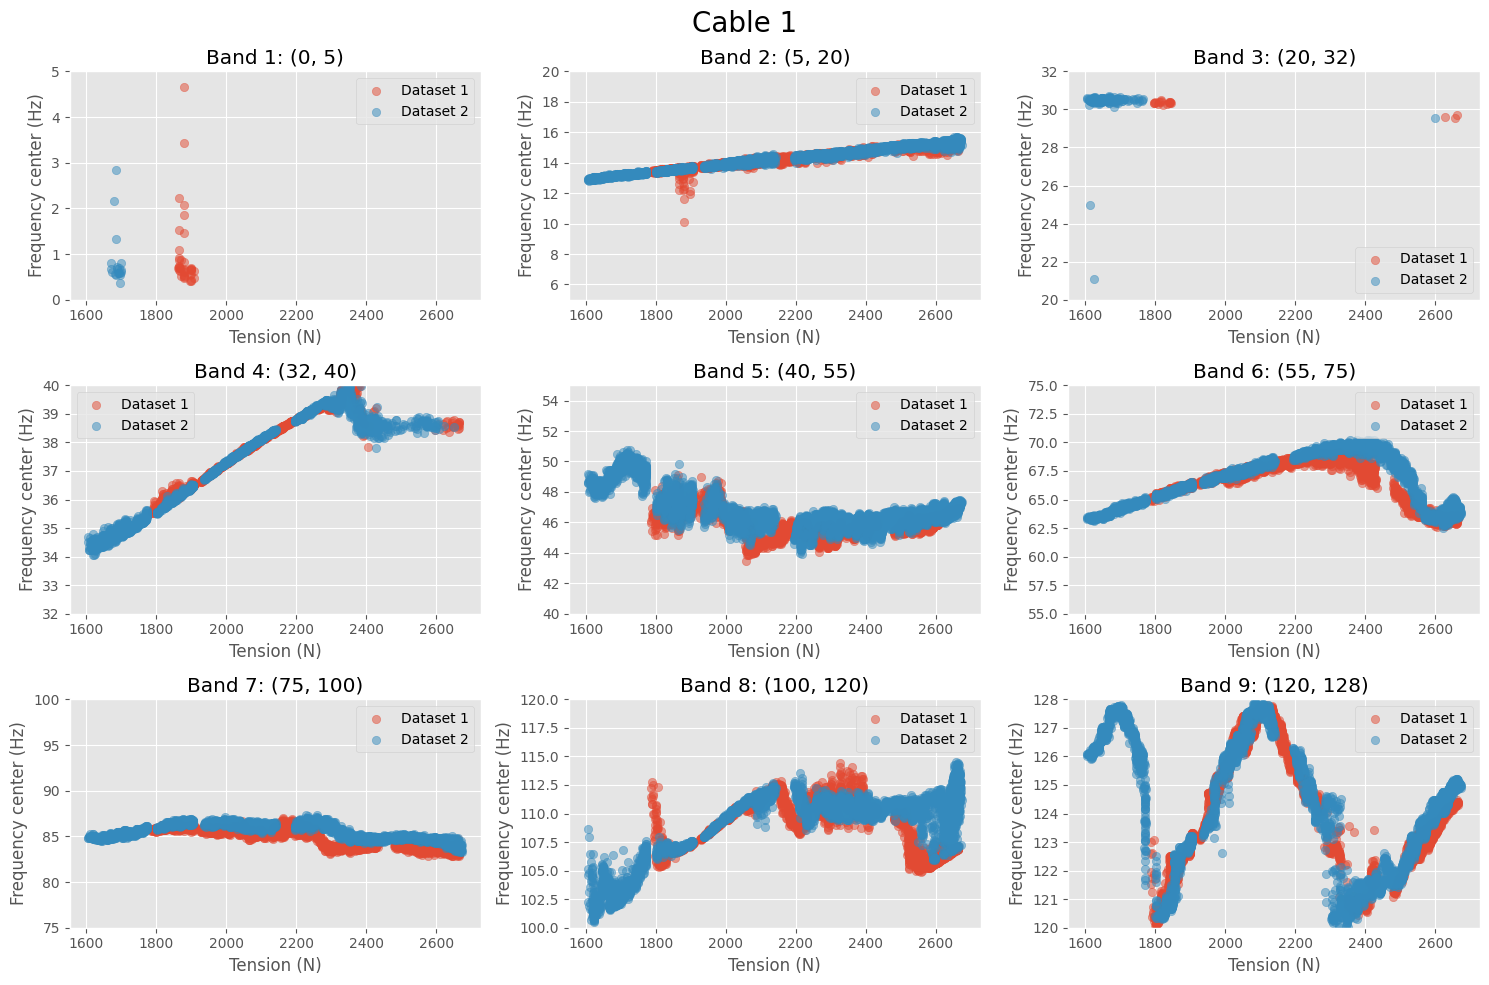

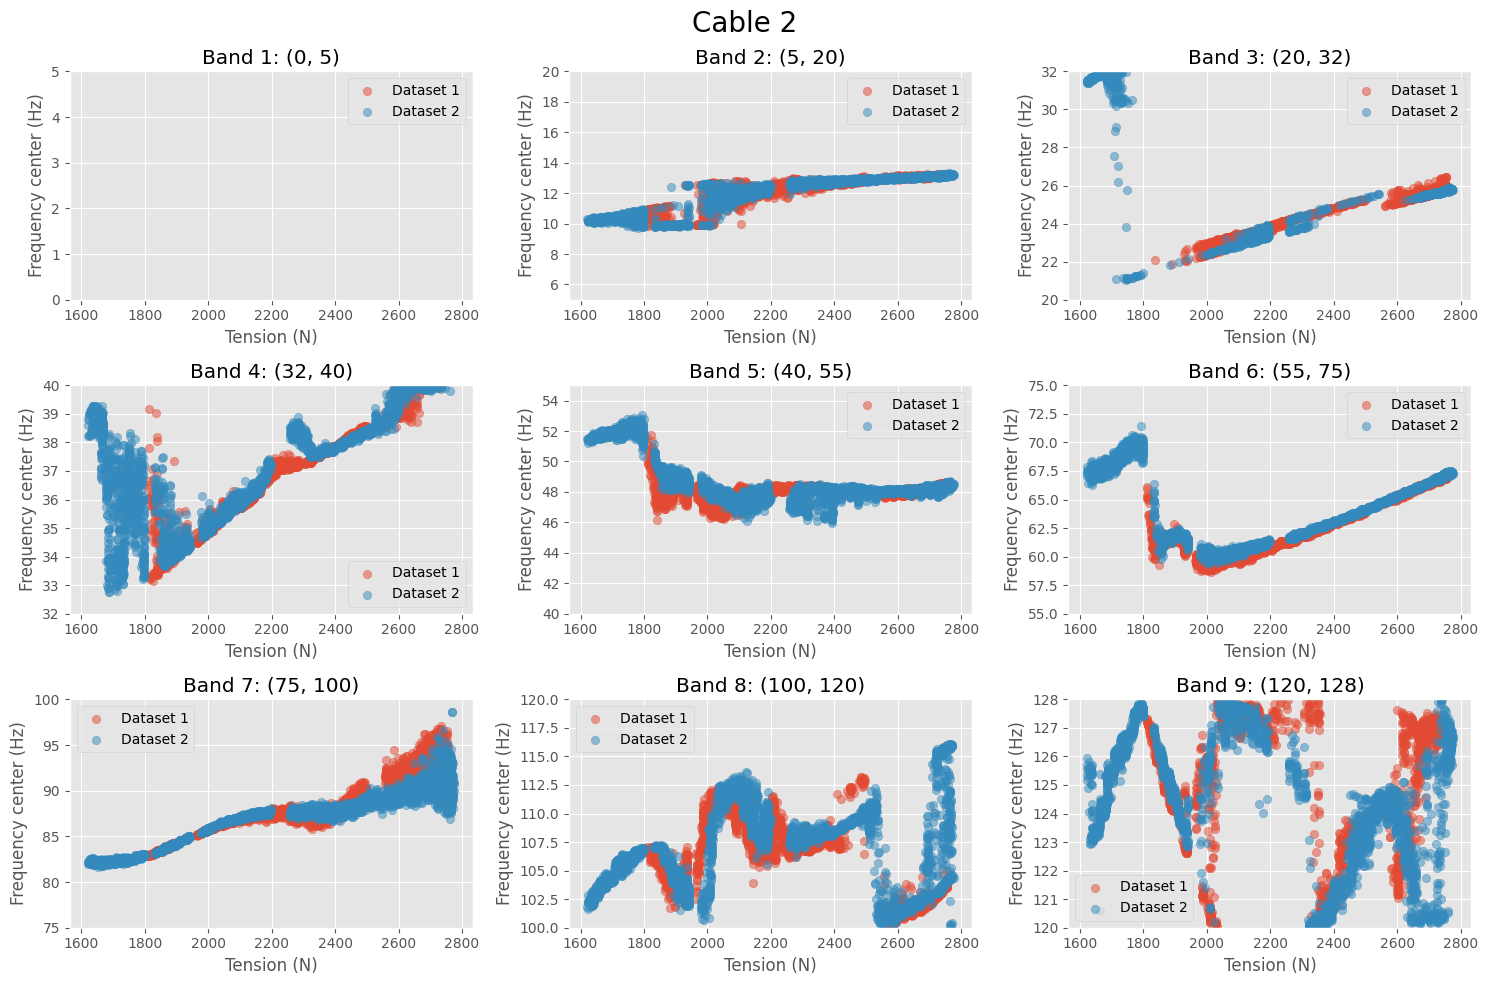

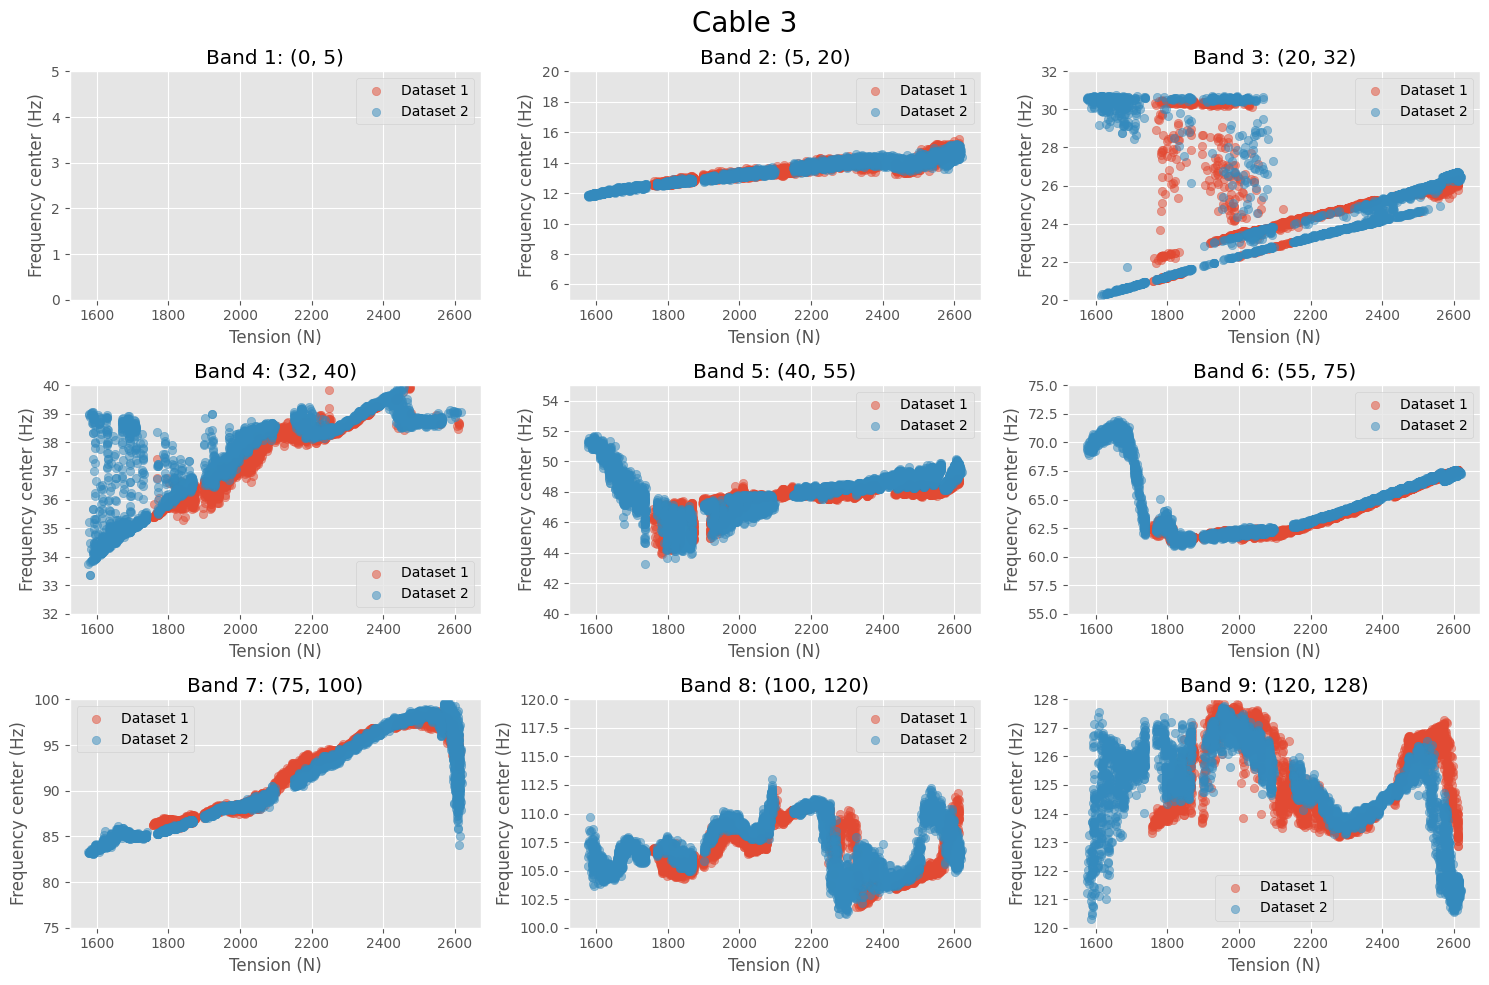

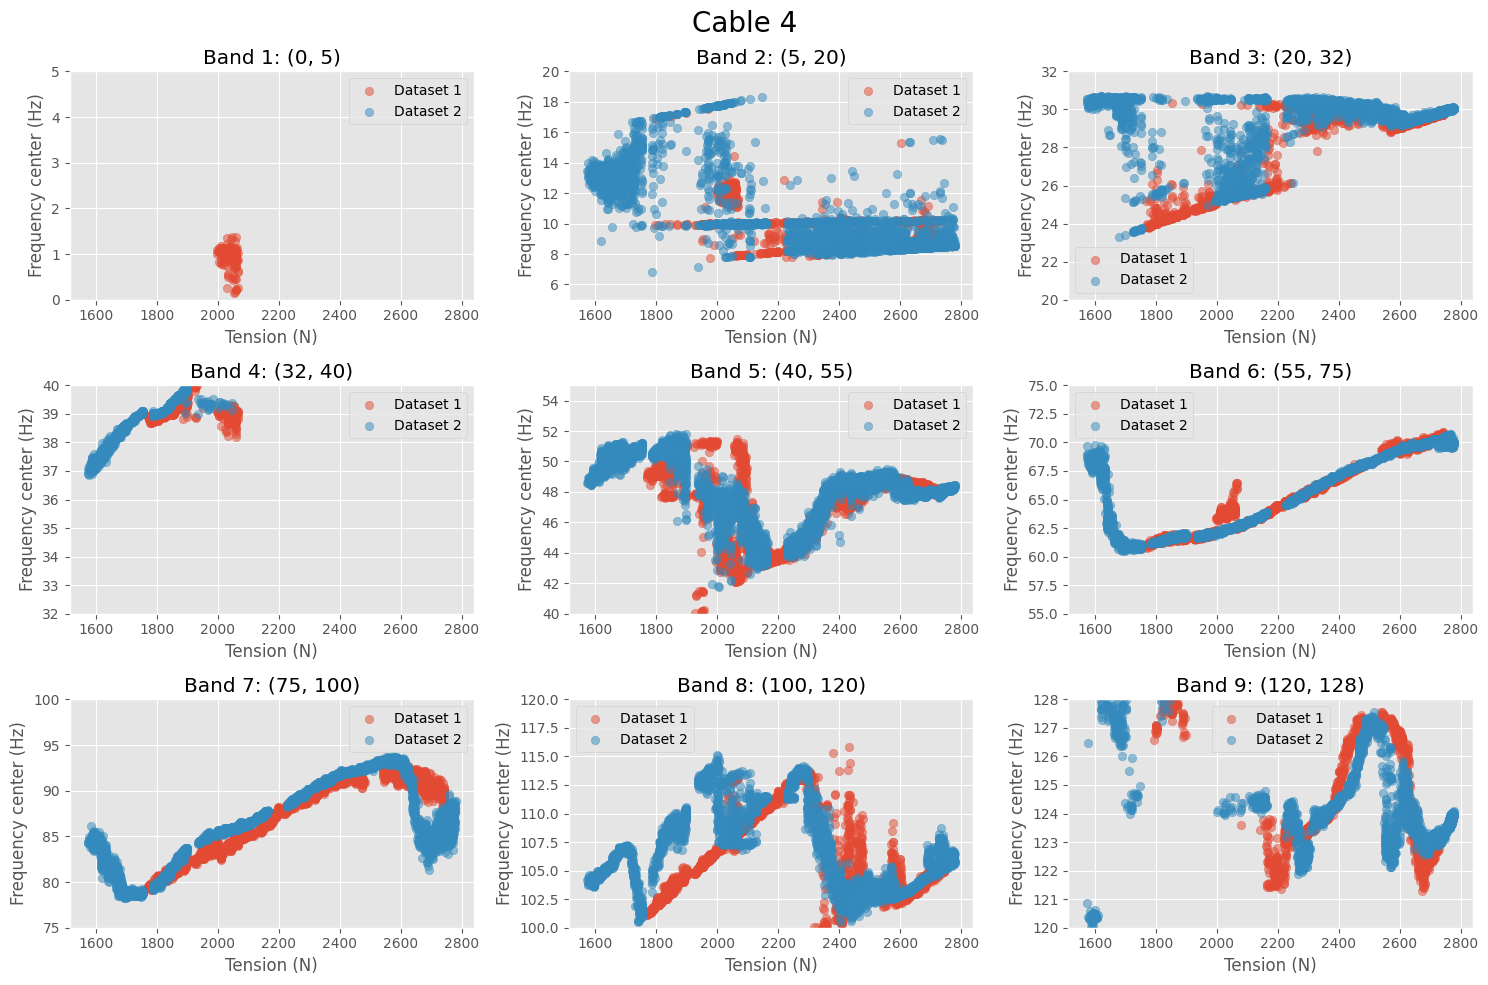

In [16]:
max_cable_1 = np.max([band_matrices_dataset_1[f"{cable}"][:,:] for cable in range(4)])
max_cable_2 = np.max([band_matrices_dataset_2[f"{cable}"][:,:] for cable in range(4)])
global_max = np.max((max_cable_1, max_cable_2))

for cable in range(4):
    plt.figure(figsize=(15,10))
    plt.suptitle(f"Cable {cable+1}", fontsize=20)
    for band in range(len(band_pairs)): 
        plt.subplot(3,3,band+1)
        plt.title(f"Band {band+1}: {band_pairs[band]}")
        plt.scatter(tensions_dataset_1[f"{cable}"], band_matrices_dataset_1[f"{cable}"][:,band], alpha=0.5)
        plt.scatter(tensions_dataset_2[f"{cable}"], band_matrices_dataset_2[f"{cable}"][:,band], alpha=0.5)
        plt.ylim(band_pairs[band])
        plt.xlabel("Tension (N)")
        plt.ylabel("Frequency center (Hz)")
        plt.legend(["Dataset 1", "Dataset 2"])
    plt.tight_layout()

# Training one model per cable

Training: dataset 2

Testing: dataset 1

In [14]:
from hmmlearn.hmm import GMMHMM

In [15]:
def initialize_left_right(n_components):
    A = np.zeros((n_components, n_components))
    for i in range(n_components-1):
        A[i,i] = 0.5
        A[i,i+1] = 0.5
    A[-1,-1] = 1
    return A

In [16]:
def initialize_left_right_common(n_components):
    A = np.zeros((n_components, n_components))
    A[-1,:] = np.ones(n_components) / n_components
    for i in range(n_components-1):
        A[i,i] = 0.5
        A[i,i+1] = 0.25
        A[i,-1] = 0.25
    A[-2,-1] = 0.5
    return A

In [17]:
def initialize_neighbor(n_components):
    A = np.zeros((n_components, n_components))
    A[0,0] = 0.5
    A[0,1] = 0.5
    A[-1,-1] = 0.5
    A[-1,-2] = 0.5
    for i in range(1, n_components-1):
        A[i,i] = 0.5
        A[i,i+1] = 0.25
        A[i,i-1] = 0.25
    
    return A

In [20]:
def train_hmm(x:np.ndarray, n_components:int, n_mix:int, initialize:callable(int)=None, covariance_type:str="full"):
    if callable(initialize):
        hmm = GMMHMM(n_components=n_components, n_mix=n_mix, init_params="smcw", covariance_type="full", min_covar=1e-3)
        hmm.transmat_ = initialize(n_components)
    else:
        hmm = GMMHMM(n_components=n_components, n_mix=n_mix, init_params="stmcw", covariance_type="full", min_covar=1e-3)
        
    # startprob = np.zeros(n_components)
    # startprob[0] = 1
    # hmm.startprob_ = startprob
    hmm.fit(x)
    return hmm

Train/test data

In [17]:
x_train = {}
x_test = {}

for cable in range(4):
    x_train[f"c{cable}"] = np.array([band_matrices_dataset_2[f"{cable}"][:,band] for band in range(len(band_pairs))]).T
    x_test[f"c{cable}"] = np.array([band_matrices_dataset_1[f"{cable}"][:,band] for band in range(len(band_pairs))]).T

In [18]:
# filtering out low variation bands

def get_iqr(x, low, high):
    x_low, x_high = np.percentile(x, [low, high], axis=0)
    iqr = x_high - x_low
    return iqr

for cable in range(4):
    iqr = get_iqr(x_train[f"c{cable}"], low=10, high=90)
    max_iqr = iqr.max()
    
    idx_to_keep = (iqr/max_iqr) > 0.1
    x_train[f"c{cable}"] = x_train[f"c{cable}"][:,idx_to_keep]
    x_test[f"c{cable}"] = x_test[f"c{cable}"][:,idx_to_keep]
    print(x_train[f"c{cable}"].shape)

(4404, 4)
(4404, 3)
(4404, 6)
(4404, 4)


In [27]:
n_components = 5
n_mix = 1

hmm_per_cable = {}
for cable in range(4):
    hmm_per_cable[f"c{cable}"] = train_hmm(
        x=x_train[f"c{cable}"], n_components=n_components, n_mix=n_mix, initialize=None, covariance_type="diag"
    )


Model is not converging.  Current: 1215.640354796718 is not greater than 4676.425483965115. Delta is -3460.785129168397
Model is not converging.  Current: -28237.52535117425 is not greater than -18329.927497515037. Delta is -9907.597853659212
Model is not converging.  Current: -35403.879053016324 is not greater than -17221.95776072613. Delta is -18181.921292290193


In [65]:
traj_train = {f"c{cable}": hmm_per_cable[f"c{cable}"].predict(x_train[f"c{cable}"]) for cable in range(4)}
traj_test = {f"c{cable}": hmm_per_cable[f"c{cable}"].predict(x_test[f"c{cable}"]) for cable in range(4)}

Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #3, mixture #0 has a null eigenvalue.


ValueError: Covariance of state #2, mixture #0 is not positive definite

In [ ]:
for cable in range(4):
    print(f"HMM transition matrix for cable {cable+1}:")
    print(np.round(hmm_per_cable[f"c{cable}"].transmat_, 5))

HMM transition matrix for cable 1:
[[3.6428e-01 5.9042e-01 2.0120e-02 2.2000e-04 1.3820e-02 1.1140e-02]
 [8.3134e-01 1.2590e-01 1.3200e-03 3.9770e-02 1.6700e-03 0.0000e+00]
 [2.7542e-01 0.0000e+00 7.2441e-01 0.0000e+00 1.7000e-04 0.0000e+00]
 [1.3818e-01 6.8988e-01 0.0000e+00 1.7194e-01 0.0000e+00 0.0000e+00]
 [7.6207e-01 3.7640e-02 0.0000e+00 0.0000e+00 2.0028e-01 0.0000e+00]
 [8.0660e-01 1.5577e-01 0.0000e+00 0.0000e+00 3.7630e-02 0.0000e+00]]
HMM transition matrix for cable 2:
[[6.4124e-01 1.1300e-02 7.6270e-02 2.7119e-01 0.0000e+00 0.0000e+00]
 [9.7300e-03 6.8482e-01 2.4708e-01 5.8370e-02 0.0000e+00 0.0000e+00]
 [2.1490e-02 5.0140e-02 9.2678e-01 1.5900e-03 0.0000e+00 0.0000e+00]
 [2.9192e-01 4.3410e-02 4.4900e-03 6.6018e-01 0.0000e+00 0.0000e+00]
 [8.9113e-01 0.0000e+00 1.0887e-01 0.0000e+00 0.0000e+00 0.0000e+00]
 [9.9994e-01 0.0000e+00 6.0000e-05 0.0000e+00 0.0000e+00 0.0000e+00]]
HMM transition matrix for cable 3:
[[8.1684e-01 1.2450e-01 9.0000e-04 3.6000e-03 4.6030e-02 8.1300e-

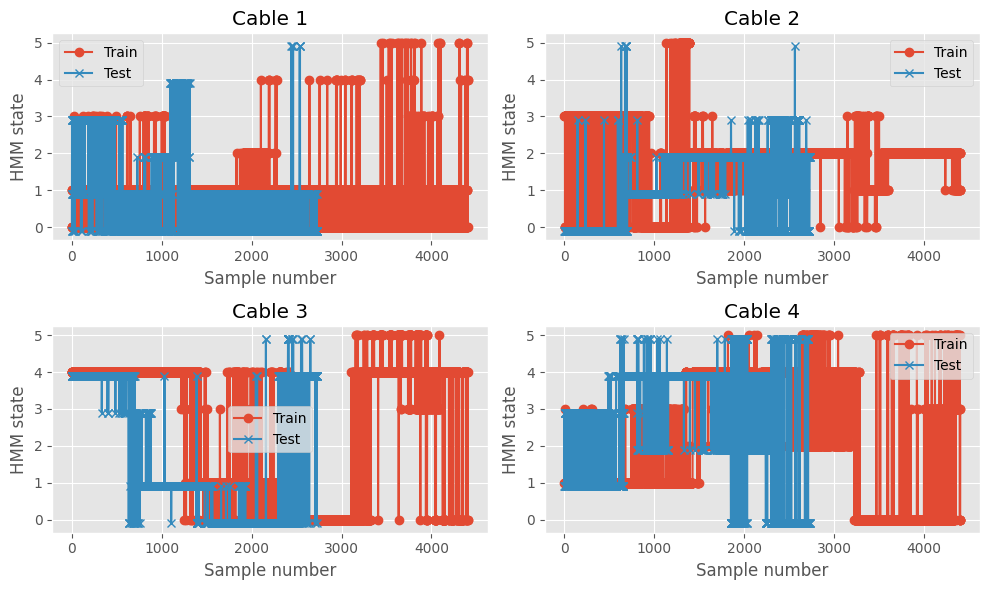

In [ ]:
plt.figure(figsize=(10,6))

for cable in range(4):
    plt.subplot(2,2,cable+1)
    plt.title(f"Cable {cable+1}")
    plt.plot(traj_train[f"c{cable}"], marker='o')
    plt.plot(traj_test[f"c{cable}"]-0.1, marker='x')
    plt.xlabel("Sample number")
    plt.ylabel("HMM state")
    plt.legend(["Train", "Test"])
plt.tight_layout()

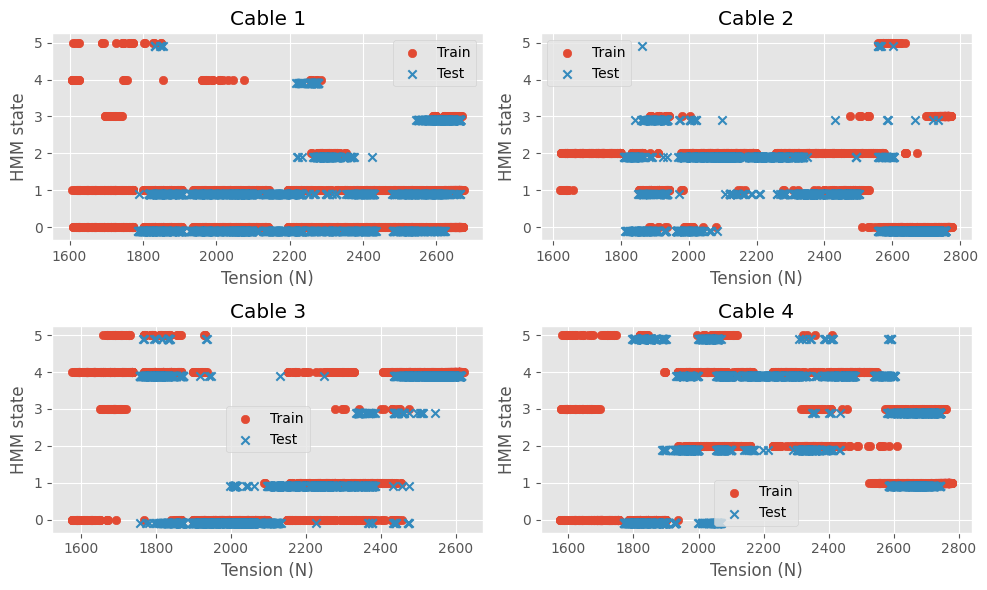

In [ ]:
plt.figure(figsize=(10,6))

for cable in range(4):
    plt.subplot(2,2,cable+1)
    plt.title(f"Cable {cable+1}")
    plt.scatter(tensions_dataset_2[f"{cable}"], traj_train[f"c{cable}"], marker='o')
    plt.scatter(tensions_dataset_1[f"{cable}"], traj_test[f"c{cable}"]-0.1, marker='x')
    plt.xlabel("Tension (N)")
    plt.ylabel("HMM state")
    plt.legend(["Train", "Test"])
plt.tight_layout()

In [ ]:
possible_train_states = np.unique(traj_train[f"c{cable}"])

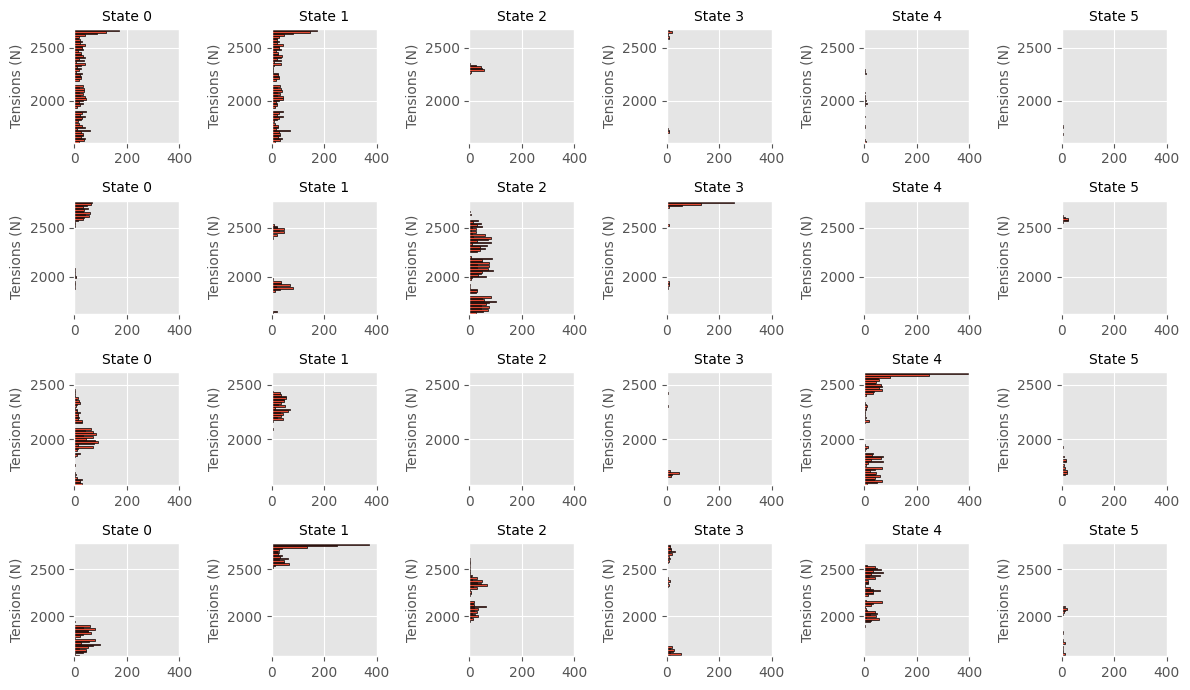

In [ ]:
plt.figure(figsize=(12,7))
for cable in range(4):
    #plt.figure(figsize=(15,2.5))
    # plt.suptitle(f"Cable {cable+1} state histograms", fontsize=16)
    #plt.figure(figsize=(15,3))
    #plt.suptitle(f"Cable {cable+1}")
    tensions = np.array(tensions_dataset_2[f"{cable}"])
    state_traj = traj_train[f"c{cable}"]
    t_min = tensions.min()
    t_max = tensions.max()
    num_states = len(possible_train_states)

    for i, state in enumerate(possible_train_states):
        plt.subplot(4, num_states, cable*num_states + i+1)
        plt.title(f"State {state}", fontsize=10)
        bins = np.arange(t_min, t_max, 15)
        plt.hist(tensions[state_traj == state], bins=bins, orientation="horizontal", edgecolor="k");
        plt.ylim([t_min, t_max])
        plt.xlim([0,400])
        plt.ylabel("Tensions (N)", fontsize=10)
    plt.tight_layout()

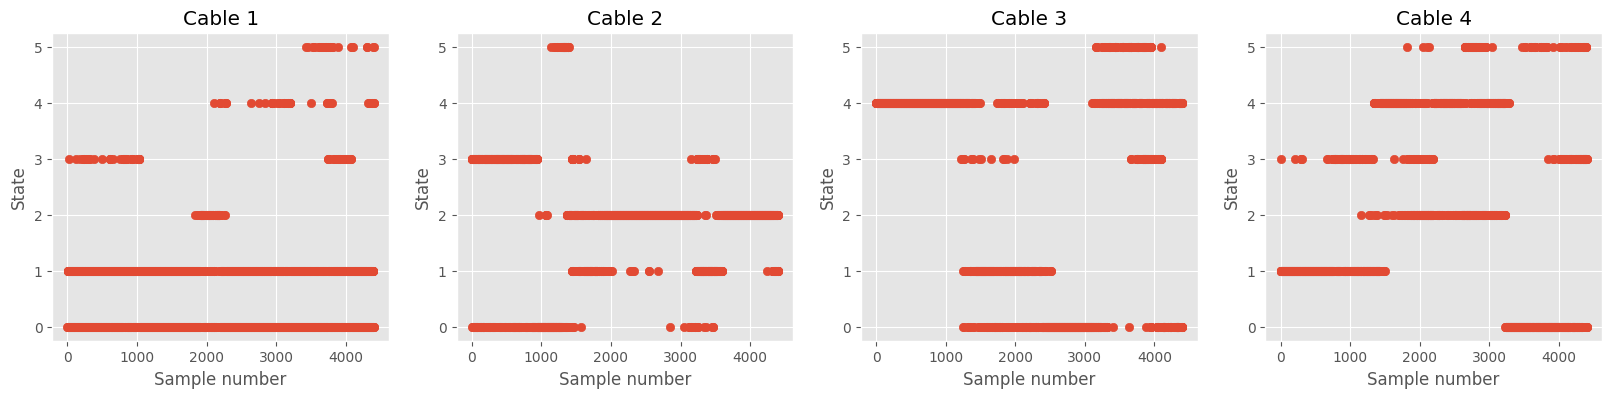

In [ ]:
plt.figure(figsize=(20,4))

for cable in range(4):
    plt.subplot(1,4,cable+1)
    plt.title(f"Cable {cable+1}")
    traj = traj_train[f"c{cable}"]
    plt.scatter(np.arange(len(traj)), traj)
    plt.xlabel("Sample number")
    plt.ylabel("State")

In [ ]:
def plot_graph(ax, adjacency_matrix):
    G = nx.from_numpy_array(adjacency_matrix)
    edges = G.edges()
    weights = np.array([G[u][v]['weight'] for u,v in edges])
    weights_mod = weights
    weights_mod[weights>=0.9] = 1.5
    weights_mod[(weights>0.1) & (weights<0.9)] = 0.75
    weights_mod[(weights>0.01) & (weights<0.1)] = 0.5
    weights_mod[(weights<0.01) & ((weights>0))] = 0.1
    weights_mod[weights==0] = 0
    nx.draw(G, ax=ax, node_size=500, with_labels=True, width=weights_mod, node_color="grey", edgecolors="k", pos=nx.circular_layout(G))

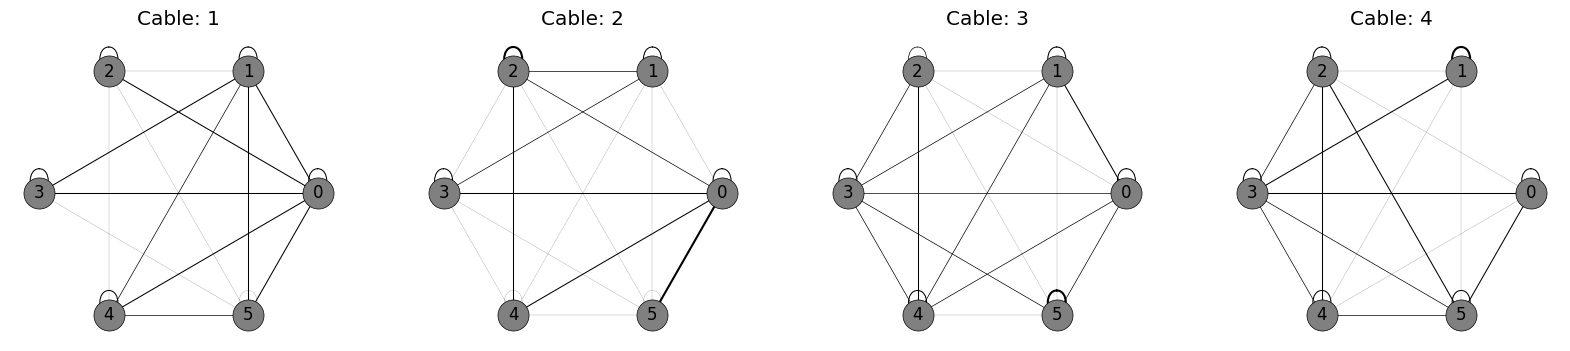

In [ ]:
fig = plt.figure(figsize=(20,4))
for cable in range(4):
    ax = fig.add_subplot(1,4,cable+1)
    plt.title(f"Cable: {cable+1}")
    plot_graph(ax=ax, adjacency_matrix=hmm_per_cable[f"c{cable}"].transmat_)